In [1]:
# Load Packages

import pandas as pd
import numpy as np
# from time import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as mpatches

## K-Means for one model

Tryring to see if it can cluster based on failure index. No good clustering. Majority of the failed ones fall in the same class as majority of good ones.

Tried for ST12000NM0007_last_day_all - raw, normalised, upsample raw upsample normalised, downsample raw, down sampe normalised
las_10_days - undersampled raw, oversampled raw

In [2]:
dataset = pd.read_csv("../dataset/ST12000NM0007_last_day_all_q_raw.csv")
dataset.shape

(38256, 24)

In [3]:
smart_attributes=['smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']

In [4]:
d_copy=dataset.copy() 
d_copy.shape
d_5f=d_copy[smart_attributes] #get only smart attributes

In [5]:
def normalize(input_frame):
    #since features are vearied by differnt scales, we normalize
    # scaler= preprocessing.StandardScaler()
    scaler= preprocessing.MinMaxScaler()
    scaler.fit(input_frame)
    data_transformed = scaler.transform(input_frame)
    return data_transformed
    

In [6]:
def plot_elbow(input_frame,plot_title="Elbow Method For Optimal k" ):
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(input_frame)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title(plot_title)
    plt.show()


In [7]:
def run_kmeans(input_frame,k=2,random_state=None, n_init=10):
    kmeans = KMeans(n_clusters=k,random_state=random_state, n_init=n_init)
    output=kmeans.fit(input_frame)
    labels=output.labels_
#     np.unique(labels, return_counts=True)
    return labels

In [8]:
def display_result_frame(input_frame,labels):
    df_new = pd.DataFrame()
    # df_new["model"] = d_copy["model"]
    df_new["serial_number"] = input_frame["serial_number"] 
    df_new["labels"] = labels
    df_new["failure"]=input_frame["failure"]
    return df_new.groupby(['failure', 'labels']).count()
    

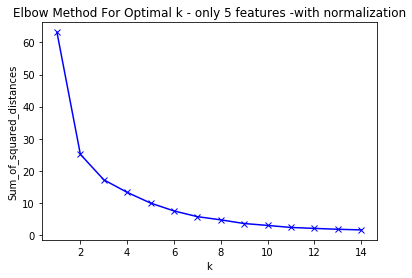

serial_number
failure labels               
0       0               36961
        1                  29
        2                  77
        3                  44
        4                   2
        5                   9
1       0                 837
        1                  80
        2                 162
        3                   5
        4                   5
        5                  45

In [9]:
data_transformed=normalize(d_5f)
plot_elbow(data_transformed,'Elbow Method For Optimal k - only 5 features -with normalization')
clustered_labels=run_kmeans(data_transformed,6)
display_result_frame(d_copy,clustered_labels)

Majority of failed points getting clustered to the cluster in which majority of the good ones present. Not a good clustering.

### Without normalization

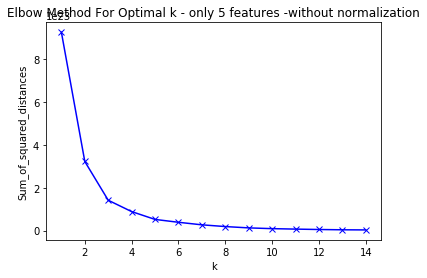

serial_number
failure labels               
0       0               36746
        1                   9
        2                   1
        3                 276
        4                  34
        5                  56
1       0                1006
        2                   2
        3                 101
        4                   3
        5                  22

In [10]:
plot_elbow(d_5f,'Elbow Method For Optimal k - only 5 features -without normalization')
clustered_labels=run_kmeans(d_5f,6,random_state=10,n_init=15)
display_result_frame(d_copy,clustered_labels)

Not a big difference than the normalised one :(

### Undersampling

#### Random under sampling

In [11]:
d_copy.groupby(['failure']).count()['serial_number']
count_good, count_bad = d_copy.failure.value_counts()
print("Good entry count: ",count_good,"\nFailed entry count: ", count_bad)

# Divide by class
df_good_all = d_copy[d_copy['failure'] == 0]
df_bad_all = d_copy[d_copy['failure'] == 1]


Good entry count:  37122 
Failed entry count:  1134


In [12]:
df_good_under = df_good_all.sample(count_bad)
df_test_under = pd.concat([df_good_under, df_bad_all], axis=0)

print('Random under-sampling:')
print(df_test_under.failure.value_counts())

Random under-sampling:
1    1134
0    1134
Name: failure, dtype: int64


In [13]:
df_under_5f=df_test_under[smart_attributes]

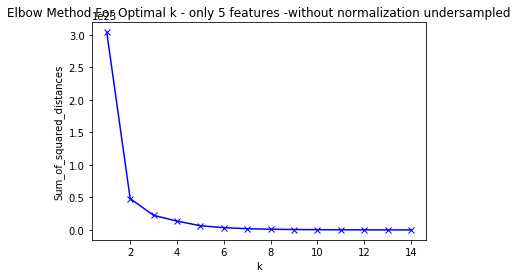

In [14]:
#without normalization
plot_elbow(df_under_5f,'Elbow Method For Optimal k - only 5 features -without normalization undersampled')

In [15]:
clustered_labels=run_kmeans(df_under_5f,4,random_state=10)
display_result_frame(df_test_under,clustered_labels)

serial_number
failure labels               
0       0                1132
        2                   2
1       0                1107
        1                   1
        2                  25
        3                   1

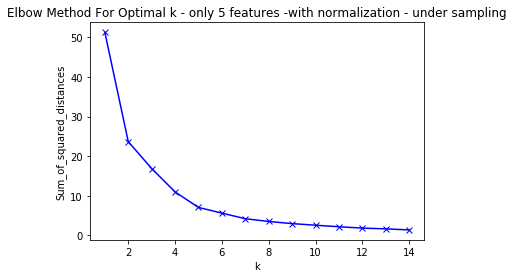

In [16]:
data_transformed=normalize(df_under_5f)
plot_elbow(data_transformed,'Elbow Method For Optimal k - only 5 features -with normalization - under sampling')


In [17]:
print(len(data_transformed))
clustered_labels=run_kmeans(data_transformed,6)
print(len(clustered_labels))
display_result_frame(df_test_under,clustered_labels)

2268
2268


serial_number
failure labels               
0       0                1130
        5                   4
1       0                 836
        1                  47
        2                   4
        3                  82
        4                   8
        5                 157

### Up Sample

In [18]:
df_bad_over = df_bad_all.sample(count_good, replace=True)
df_test_over = pd.concat([df_good_all, df_bad_over], axis=0)

print('Random over-sampling:')
print(df_test_over.failure.value_counts())

Random over-sampling:
1    37122
0    37122
Name: failure, dtype: int64


In [19]:
df_over_5f=df_test_over[smart_attributes]

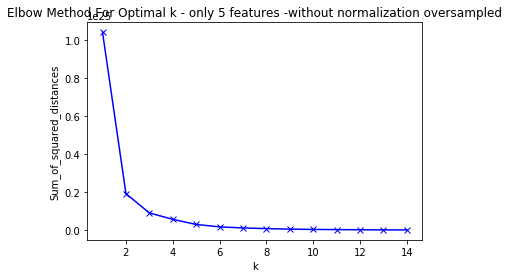

In [20]:
#without normalization
plot_elbow(df_over_5f,'Elbow Method For Optimal k - only 5 features -without normalization oversampled')

In [21]:
clustered_labels=run_kmeans(df_over_5f,4,random_state=10)
display_result_frame(df_test_over,clustered_labels)

serial_number
failure labels               
0       0               37034
        1                   5
        2                  83
1       0               36470
        1                  34
        2                 586
        3                  32

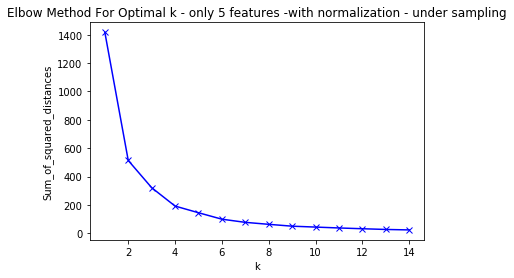

In [22]:
data_transformed=normalize(df_over_5f)
plot_elbow(data_transformed,'Elbow Method For Optimal k - only 5 features -with normalization - under sampling')

In [23]:
clustered_labels=run_kmeans(data_transformed,6,random_state=10)
display_result_frame(df_test_over,clustered_labels)

serial_number
failure labels               
0       0               37003
        1                   9
        2                  77
        3                   4
        5                  29
1       0               27673
        1                1566
        2                5215
        3                  66
        4                 132
        5                2470

In [24]:
from sklearn.decomposition import PCA
# df_allf=d_copy.iloc[:,5:]
df_allf_norm=normalize(d_copy.iloc[:,5:])
pca = PCA(n_components=2)
X = pca.fit_transform(df_allf_norm)

labels=d_copy['failure']    

Text(0.5, 0, 'feature 2')

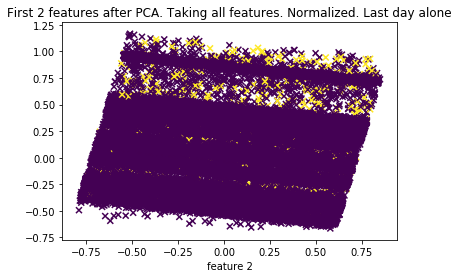

In [25]:
plt.scatter(X[:,0],X[:,1],c=labels,marker='x')
plt.title("First 2 features after PCA. Taking all features. Normalized. Last day alone")
plt.xlabel("feature 1")
plt.xlabel("feature 2")
# X.shape

In [26]:
# df_allf=d_copy.iloc[:,5:]
df_5f_norm=normalize(d_5f)
print(d_5f.shape)
print(df_5f_norm.shape)
pca = PCA(n_components=2)
X = pca.fit_transform(df_5f_norm)
labels=d_copy['failure']   
print(len(d_copy))

(38256, 5)
(38256, 5)
38256


Text(0.5, 0, 'feature 2')

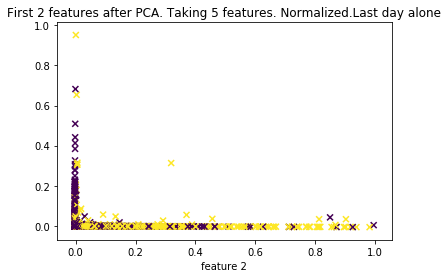

In [27]:
plt.scatter(X[:,0],X[:,1],c=labels,marker='x')
plt.title("First 2 features after PCA. Taking 5 features. Normalized.Last day alone")
plt.xlabel("feature 1")
plt.xlabel("feature 2")
# X.shape

## Trying for 10 days

In [28]:
dataset = pd.read_csv("../dataset/ST12000NM0007_last_10_day_all_q_raw.csv")
dataset.shape

(382305, 24)

In [29]:
d_copy=dataset.copy()
count_good, count_bad = dataset.failure.value_counts()
print("Good entry count: ",count_good,"\nFailed entry count: ", count_bad)

# Divide by class
df_good_all = d_copy[d_copy['failure'] == 0]
df_bad_all = d_copy[d_copy['failure'] == 1]


Good entry count:  371048 
Failed entry count:  11257


In [30]:
df_good_under = df_good_all.sample(count_bad)
df_test_under = pd.concat([df_good_under, df_bad_all], axis=0)

print('Random under-sampling:')
print(df_test_under.failure.value_counts())

Random under-sampling:
1    11257
0    11257
Name: failure, dtype: int64


In [31]:
df_under_5f=df_test_under[smart_attributes]

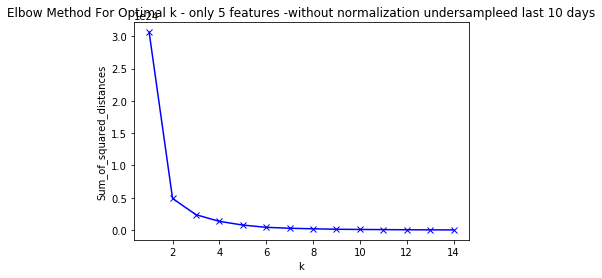

In [32]:
#without normalization
plot_elbow(df_under_5f,'Elbow Method For Optimal k - only 5 features -without normalization undersampleed last 10 days')

In [33]:
clustered_labels=run_kmeans(df_under_5f,2,random_state=10)
display_result_frame(df_test_under,clustered_labels)

serial_number
failure labels               
0       0               11256
        1                   1
1       0               11237
        1                  20

In [34]:
# Increase failed sample count
df_bad_over = df_bad_all.sample(count_good, replace=True)
df_test_over = pd.concat([df_good_all, df_bad_over], axis=0)

print('Random over-sampling:')
print(df_test_over.failure.value_counts())

Random over-sampling:
1    371048
0    371048
Name: failure, dtype: int64


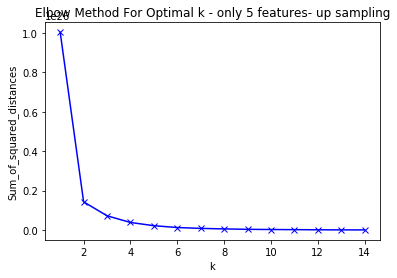

In [35]:
df_over_5f=df_test_over[smart_attributes]
plot_elbow(df_over_5f,'Elbow Method For Optimal k - only 5 features- up sampling')

In [36]:
clustered_labels=run_kmeans(df_over_5f,2,random_state=10)
display_result_frame(df_test_over,clustered_labels)

serial_number
failure labels               
0       0              371008
        1                  40
1       0              370381
        1                 667

## Trying to cluster by Model

In [37]:
def get_all_models(number_of_days):
    st_models = req_models = ['ST12000NM0007', 'ST4000DM000', 'ST8000NM0055', 'ST8000DM002']
    df_final = pd.DataFrame()
    for name in st_models:
        full_name = name + number_of_days
        dataset = pd.read_csv("../dataset/" + full_name)
        df = dataset[['model', 'capacity_bytes','serial_number', 'smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']]
        df_final = df_final.append(df, ignore_index=True)
    return df_final

In [38]:
number_of_days="_last_day_all_q_raw.csv"
df_all_model=get_all_models(number_of_days)
df_all_5f=df_all_model[smart_attributes]
df_all_5f['capacity_bytes']=df_all_model['capacity_bytes']
df_all_5f

c:\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,capacity_bytes
0,0.0,0.0,0.0,0.0,0.0,12000138625024
1,0.0,0.0,0.0,0.0,0.0,12000138625024
2,4809.0,1.0,0.0,0.0,0.0,12000138625024
3,0.0,0.0,0.0,0.0,0.0,12000138625024
4,0.0,0.0,0.0,0.0,0.0,12000138625024
...,...,...,...,...,...,...
86260,0.0,0.0,0.0,0.0,0.0,8001563222016
86261,0.0,0.0,0.0,0.0,0.0,8001563222016
86262,0.0,0.0,0.0,0.0,0.0,8001563222016
86263,0.0,0.0,0.0,0.0,0.0,8001563222016


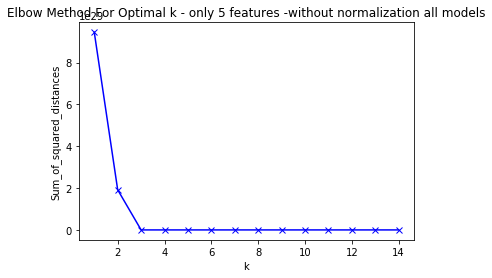

In [39]:
#without normalization
plot_elbow(df_all_5f,'Elbow Method For Optimal k - only 5 features -without normalization all models')

In [40]:
clustered_labels=run_kmeans(df_all_5f,4)
print(len(clustered_labels))
# display_result_frame(df_all_5f,clustered_labels)
df_res = pd.DataFrame()
df_res["serial_number"] = df_all_model["serial_number"] 
df_res["model"] = df_all_model["model"] 
df_res["labels"] = clustered_labels
df_res.groupby(['model', 'labels']).count()

86265


serial_number
model         labels               
ST12000NM0007 2               38210
              3                  46
ST4000DM000   1               23394
ST8000DM002   0                9936
ST8000NM0055  0               14679

In [41]:
df_all_model.groupby(['model']).count()

,capacity_bytes,serial_number,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw
model,,,,,,,
ST12000NM0007,38256,38256,38256,38256,38256,38256,38256
ST4000DM000,23394,23394,23394,23394,23394,23394,23394
ST8000DM002,9936,9936,9936,9936,9936,9936,9936
ST8000NM0055,14679,14679,14679,14679,14679,14679,14679


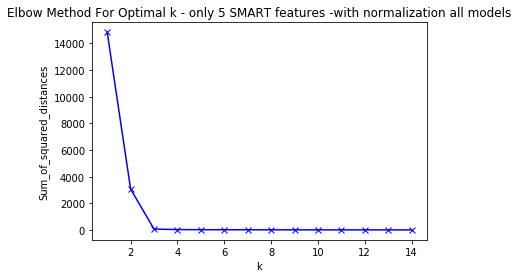

In [42]:
data_transformed=normalize(df_all_5f)
plot_elbow(data_transformed,'Elbow Method For Optimal k - only 5 SMART features -with normalization all models')

In [43]:
clustered_labels=run_kmeans(data_transformed,4)
# display_result_frame(df_all_5f,clustered_labels)
df_res = pd.DataFrame()
df_res["serial_number"] = df_all_model["serial_number"] 
df_res["model"] = df_all_model["model"] 
df_res["labels"] = clustered_labels
df_res.groupby(['model', 'labels']).count()

serial_number
model         labels               
ST12000NM0007 0               38085
              3                 171
ST4000DM000   1               23394
ST8000DM002   2                9936
ST8000NM0055  2               14675
              3                   4

### Trying PCA with capacity bytes:

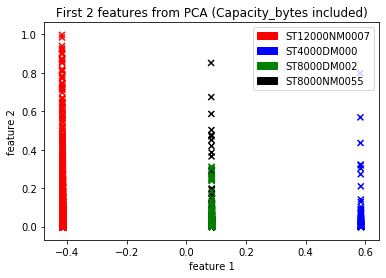

In [47]:
df_allf=data_transformed.copy()
pca = PCA(n_components=2) #to visualise
X = pca.fit_transform(df_allf)
colors = {'ST12000NM0007':'red', 'ST4000DM000':'blue', 'ST8000DM002':'green', 'ST8000NM0055':'black'}

# labels=df_all_model['model_label']
labels=df_all_model['model']

# plt.scatter(X[:,0],X[:,1],c=labels,label=labels, marker='x')
plt.scatter(X[:,0],X[:,1], c=labels.apply(lambda x: colors[x]) , marker='x')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("First 2 features from PCA (Capacity_bytes included)")
red = mpatches.Patch(color='red', label='ST12000NM0007')
blue = mpatches.Patch(color='blue', label='ST4000DM000')
green = mpatches.Patch(color='green', label='ST8000DM002')
black = mpatches.Patch(color='black', label='ST8000NM0055')
plt.legend(handles=[red,blue,green,black])

In [48]:
df_no_cap=df_all_5f.drop(['capacity_bytes'],axis=1)
df_no_cap #No capacity original data for all models

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,4809.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
86260,0.0,0.0,0.0,0.0,0.0
86261,0.0,0.0,0.0,0.0,0.0
86262,0.0,0.0,0.0,0.0,0.0
86263,0.0,0.0,0.0,0.0,0.0


(86265, 2)


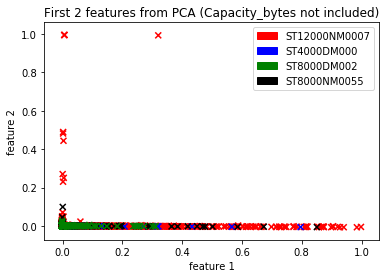

In [49]:
norm_df_no_cap=normalize(df_no_cap)
pca = PCA(n_components=2) #to visualise
X = pca.fit_transform(norm_df_no_cap)
print(X.shape)
colors = {'ST12000NM0007':'red', 'ST4000DM000':'blue', 'ST8000DM002':'green', 'ST8000NM0055':'black'}

# labels=df_all_model['model_label']
labels=df_all_model['model']

# plt.scatter(X[:,0],X[:,1],c=labels,label=labels, marker='x')
plt.scatter(X[:,0],X[:,1], c=labels.apply(lambda x: colors[x]) , marker='x', label=['red','b','c','d'])
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("First 2 features from PCA (Capacity_bytes not included)")
red = mpatches.Patch(color='red', label='ST12000NM0007')
blue = mpatches.Patch(color='blue', label='ST4000DM000')
green = mpatches.Patch(color='green', label='ST8000DM002')
black = mpatches.Patch(color='black', label='ST8000NM0055')
plt.legend(handles=[red,blue,green,black])
